# Installing libraries

In [1]:
!pip install -U pynwb --quiet
!pip install wget --quiet
!pip install pytorch-lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.0/134.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.0/332.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 12.6 MB/s eta 0:00:00


# Imports

In [2]:
import os
import wget
import zipfile
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
from torch.utils.data import Dataset, TensorDataset, DataLoader
from IPython.display import Audio, display

##For Containerisation

In [3]:
!python --version


Python 3.10.12


In [4]:
requirements = !pip freeze

In [5]:
with open('requirements.txt', 'w') as file:
    for value in requirements:
        file.write(f"{value}\n")

# Download and unpack data

In [7]:
wget.download("https://osf.io/download/g6q5m/", "SingleWordProductionDutch-iBIDS.zip")

'SingleWordProductionDutch-iBIDS.zip'

In [8]:
with zipfile.ZipFile('SingleWordProductionDutch-iBIDS.zip', 'r') as zip_ref:
  zip_ref.extractall()
os.remove('SingleWordProductionDutch-iBIDS.zip')

# Processing data

In [9]:
!wget https://raw.githubusercontent.com/eva-vision/2BRAINS/main/MelFilterBank.py --quiet
!wget https://raw.githubusercontent.com/eva-vision/2BRAINS/main/extract_features.py --quiet
!wget https://raw.githubusercontent.com/eva-vision/2BRAINS/main/reconstructWave.py --quiet

In [10]:
!python MelFilterBank.py
!python reconstructWave.py --quiet
!python extract_features.py

In [11]:
import reconstructWave as rW
import MelFilterBank as mel

# Training

The Network

In [12]:
# Define the neural network architecture
class TimeSeriesNet(nn.Module):
    def __init__(self):
        super(TimeSeriesNet, self).__init__()

        # Input layer
        self.input = nn.Linear(1143, 512)

        # Hidden layers
        self.hidden1 = nn.Linear(512, 256)
        self.hidden2 = nn.Linear(256, 256)
        self.hidden3 = nn.Linear(256, 128)
        self.hidden4 = nn.Linear(128, 64)

        # Output layer
        self.output = nn.Linear(64, 23)

        # Batch normalization layers
        self.bn_input = nn.BatchNorm1d(512)
        self.bn_hidden1 = nn.BatchNorm1d(256)
        self.bn_hidden2 = nn.BatchNorm1d(256)
        self.bn_hidden3 = nn.BatchNorm1d(128)
        self.bn_hidden4 = nn.BatchNorm1d(64)

    def forward(self, x):
        # Input layer with activation and normalization
        x = F.relu(self.bn_input(self.input(x)))

        # Hidden layers with activation and normalization
        x = F.relu(self.bn_hidden1(self.hidden1(x)))
        x = F.relu(self.bn_hidden2(self.hidden2(x)))
        x = F.relu(self.bn_hidden3(self.hidden3(x)))
        x = F.relu(self.bn_hidden4(self.hidden4(x)))

        # Output layer
        x = self.output(x)
        return x

In [14]:
result_path = r'./results'
feat_path = r'./features'
os.makedirs(os.path.join(result_path), exist_ok=True)
pt = 'sub-01'

In [15]:
_data = np.load(os.path.join(feat_path,f'{pt}_feat.npy'))
_spectrogram = np.load(os.path.join(feat_path,f'{pt}_spec.npy'))

## Baseline training

In [17]:
X_train, X_test, y_train, y_test = train_test_split(_data, _spectrogram, test_size=0.20, random_state=42)

In [18]:
class TimeSeriesDataset(Dataset):
    def __init__(self):
        # Load data
        self.X = X_train
        self.y = y_train

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

dataset = TimeSeriesDataset()


# Create data loader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [48]:
# Define a loss function and optimizer
time_series_net_baseline = TimeSeriesNet()
criterion = nn.MSELoss()  # Mean Squared Error Loss, common for regression tasks
optimizer = optim.Adam(time_series_net_baseline.parameters(), lr=0.001)  # Using Adam optimizer

# Function to train the network
def train_network(net, dataloader, epochs=5):
    net.train()  # Set the network into training mode

    for epoch in range(epochs):  # Loop over the dataset multiple times
        running_loss = 0.0

        for i, data in enumerate(dataloader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # Print every 100 mini-batches
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
                running_loss = 0.0

    print('Finished Training')

    # Save the model checkpoint
    checkpoint_path = '/content/Basline_Checkpoint.ckpt'
    torch.save(time_series_net_baseline.state_dict(), checkpoint_path)
    print(f"Model checkpoint saved to {checkpoint_path}")

# Example usage
train_network(time_series_net_baseline, dataloader, epochs=5)

Epoch 1, Batch 100, Loss: 14.414931836128234
Epoch 1, Batch 200, Loss: 4.034159905910492
Epoch 1, Batch 300, Loss: 2.8948627734184265
Epoch 1, Batch 400, Loss: 2.5558842718601227
Epoch 1, Batch 500, Loss: 2.3931198477745057
Epoch 1, Batch 600, Loss: 2.239835342168808
Epoch 1, Batch 700, Loss: 2.2817201900482176
Epoch 2, Batch 100, Loss: 1.9318820750713348
Epoch 2, Batch 200, Loss: 1.935318558216095
Epoch 2, Batch 300, Loss: 2.0336792129278183
Epoch 2, Batch 400, Loss: 1.9873959296941757
Epoch 2, Batch 500, Loss: 1.8766443997621536
Epoch 2, Batch 600, Loss: 1.9979380267858504
Epoch 2, Batch 700, Loss: 1.7181135499477387
Epoch 3, Batch 100, Loss: 1.712414858341217
Epoch 3, Batch 200, Loss: 1.7138379722833634
Epoch 3, Batch 300, Loss: 1.824782287478447
Epoch 3, Batch 400, Loss: 1.6712942308187484
Epoch 3, Batch 500, Loss: 1.5654920738935472
Epoch 3, Batch 600, Loss: 1.652858654856682
Epoch 3, Batch 700, Loss: 1.559295887351036
Epoch 4, Batch 100, Loss: 1.511326054930687
Epoch 4, Batch 200

### Prediction

In [49]:
def infer(net, input_data):
    net.eval()  # Set the network to evaluation mode

    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        inputs = torch.tensor(input_data, dtype=torch.float32)

        # Check if the network is on a GPU and move the inputs to the same device
        if next(net.parameters()).is_cuda:
            inputs = inputs.to('cuda')

        outputs = net(inputs)
        return outputs

# Example usage
# input_data = [array of your new input data]  # Replace with your input data
predictions_baseline = infer(time_series_net_baseline, _data)
print(predictions_baseline)

tensor([[4.0348, 4.7245, 4.4422,  ..., 3.5950, 3.4726, 2.3750],
        [4.0671, 4.7745, 4.4892,  ..., 3.6474, 3.5161, 2.3770],
        [4.1086, 4.8510, 4.5684,  ..., 3.6959, 3.5451, 2.3611],
        ...,
        [4.1396, 4.8049, 4.5119,  ..., 3.7144, 3.6005, 2.4717],
        [4.3015, 5.0293, 4.6951,  ..., 3.8066, 3.6896, 2.5149],
        [4.3636, 5.1012, 4.6905,  ..., 3.7687, 3.6790, 2.5077]])


### Metrics

In [50]:
# Calculate metrics for the baseline model
baseline_mae = mean_absolute_error(_spectrogram, predictions_baseline)
baseline_mse = mean_squared_error(_spectrogram, predictions_baseline)
baseline_r2 = r2_score(_spectrogram, predictions_baseline)
# Create a DataFrame to store the results
baseline_results = pd.DataFrame({'MAE': [baseline_mae], 'MSE': [baseline_mse], 'R2 Score': [baseline_r2]})
# Save the results to a CSV file
baseline_results.to_csv(os.path.join(result_path, 'baseline_results.csv'), index=False)
print(baseline_results)

        MAE       MSE  R2 Score
0  0.697502  1.067786  0.672865


### Visualisation

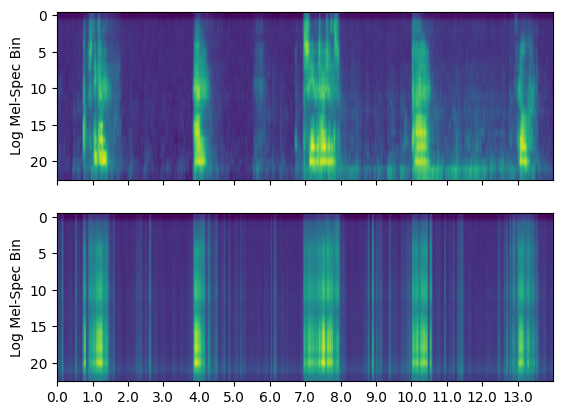

In [51]:
# Viz example spectrogram
#Which timeframe to plot
start_s = 5.5
stop_s = 19.5

frameshift = 0.01
#Load spectrograms
rec_spec = predictions_baseline
spectrogram = _spectrogram
#Load prompted words
#eeg_sr= 1024
#words = np.load(os.path.join(feat_path,f'{participant}_procWords.npy'))[int(start_s*eeg_sr):int(stop_s*eeg_sr)]
#words = [words[w] for w in np.arange(1,len(words)) if words[w]!=words[w-1] and words[w]!='']


cm='viridis'
fig, ax = plt.subplots(2, sharex=True)
#Plot spectrograms
pSta=int(start_s*(1/frameshift));pSto=int(stop_s*(1/frameshift))
ax[0].imshow(np.flipud(spectrogram[pSta:pSto, :].T), cmap=cm, interpolation=None,aspect='auto')
ax[0].set_ylabel('Log Mel-Spec Bin')
ax[1].imshow(np.flipud(rec_spec[pSta:pSto, :].T), cmap=cm, interpolation=None,aspect='auto')
plt.setp(ax[1], xticks=np.arange(0,pSto-pSta,int(1/frameshift)), xticklabels=[str(x/int(1/frameshift)) for x in np.arange(0,pSto-pSta,int(1/frameshift))])
#plt.setp(ax[1], xticks=np.arange(int(1/frameshift),spectrogram[pSta:pSto, :].shape[0],3*int(1/frameshift)), xticklabels=words)
ax[1].set_ylabel('Log Mel-Spec Bin')

plt.savefig(os.path.join(result_path,'spec_example_baseline.png'),dpi=600)

plt.show()

### Audio output

In [23]:
def createAudio(spectrogram, audiosr=16000, winLength=0.05, frameshift=0.01):
  """
  Create a reconstructed audio wavefrom

  Parameters
  ----------
  spectrogram: array
  Spectrogram of the audio
  sr: int
  Sampling rate of the audio
  windowLength: float
  Length of window (in seconds) in which spectrogram was calculated
  frameshift: float
  Shift (in seconds) after which next window was extracted
  Returns
  ----------
  scaled: array
  Scaled audio waveform
  """
  mfb = mel.MelFilterBank(int((audiosr*winLength)/2+1), spectrogram.shape[1], audiosr)
  nfolds = 1
  hop = int(spectrogram.shape[0]/nfolds)
  rec_audio = np.array([])
  for_reconstruction = mfb.fromLogMels(spectrogram)
  for w in range(0,spectrogram.shape[0],hop):
    spec = for_reconstruction[w:min(w+hop,for_reconstruction.shape[0]),:]
  rec = rW.reconstructWavFromSpectrogram(spec,spec.shape[0]*spec.shape[1],fftsize=int(audiosr*winLength),overlap=int(winLength/frameshift))
  rec_audio = np.append(rec_audio,rec)
  scaled = np.int16(rec_audio/np.max(np.abs(rec_audio)) * 32767)
  return scaled

In [24]:
audiosr = 16000
winLength = 0.05
frameshift = 0.01
np.save(os.path.join(result_path,f'{pt}_predicted_spec_baseline.npy'), predictions_baseline)
#Synthesize waveform from spectrogram using Griffin-Lim
reconstructedWav = createAudio(predictions_baseline,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join(result_path,f'{pt}_predicted_baseline.wav'),int(audiosr),reconstructedWav)

In [25]:
#For comparison synthesize the original spectrogram with Griffin-Lim
origWav = createAudio(_spectrogram,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join(result_path,f'{pt}_orig_synthesized_baseline.wav'),int(audiosr),origWav)

In [ ]:
from IPython.display import Audio, display
print("Original synthesized\n")
display(Audio(os.path.join(result_path,f'{pt}_orig_synthesized_baseline.wav'), autoplay=False))
print("\nPredicted\n")
display(Audio(os.path.join(result_path,f'{pt}_predicted_baseline.wav'), autoplay=False))

## Final training

In [52]:
X = _data
y = _spectrogram

In [53]:
kf = KFold(n_splits=5)

batch_size = 32
epoch_number = 5
learning_rate = 0.001

time_series_net_final = TimeSeriesNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(time_series_net_final.parameters(), lr=learning_rate)

# Loop over each fold
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Training on fold {fold+1}/5...")

    # Split the data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create Tensor datasets
    train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

    # Create Data Loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    #Train loop
    time_series_net_final.train()
    for epoch in range(epoch_number):  # Loop over the dataset multiple times
        running_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = time_series_net_final(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # Print every 100 mini-batches
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
                running_loss = 0.0

print('Finished Training')

# Save the model checkpoint
checkpoint_path = '/content/Final_Checkpoint.ckpt'
torch.save(time_series_net_final.state_dict(), checkpoint_path)
print(f"Model checkpoint saved to {checkpoint_path}")

Training on fold 1/5...
Epoch 1, Batch 100, Loss: 14.958875873088836
Epoch 1, Batch 200, Loss: 3.4374302315711973
Epoch 1, Batch 300, Loss: 2.649302797317505
Epoch 1, Batch 400, Loss: 2.5604787266254423
Epoch 1, Batch 500, Loss: 2.3228587663173674
Epoch 1, Batch 600, Loss: 2.250758084654808
Epoch 1, Batch 700, Loss: 2.2052376556396482
Epoch 2, Batch 100, Loss: 1.9477818185091018
Epoch 2, Batch 200, Loss: 1.9103001636266708
Epoch 2, Batch 300, Loss: 1.778203605413437
Epoch 2, Batch 400, Loss: 1.685106123685837
Epoch 2, Batch 500, Loss: 1.7634200745820998
Epoch 2, Batch 600, Loss: 1.8308385401964187
Epoch 2, Batch 700, Loss: 1.906829099059105
Epoch 3, Batch 100, Loss: 1.544639414548874
Epoch 3, Batch 200, Loss: 1.429622323513031
Epoch 3, Batch 300, Loss: 1.4986059617996217
Epoch 3, Batch 400, Loss: 1.6076974314451218
Epoch 3, Batch 500, Loss: 1.55811363697052
Epoch 3, Batch 600, Loss: 1.5693721854686737
Epoch 3, Batch 700, Loss: 1.4957558619976044
Epoch 4, Batch 100, Loss: 1.311678880751

### Prediction

In [54]:
def infer(net, input_data):
    net.eval()  # Set the network to evaluation mode

    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        inputs = torch.tensor(input_data, dtype=torch.float32)

        # Check if the network is on a GPU and move the inputs to the same device
        if next(net.parameters()).is_cuda:
            inputs = inputs.to('cuda')

        outputs = net(inputs)
        return outputs

# Example usage
# input_data = [array of your new input data]  # Replace with your input data
predictions_final = infer(time_series_net_final, _data)
print(predictions_final)

tensor([[3.7143, 4.4303, 3.7852,  ..., 3.6151, 3.4147, 2.3359],
        [3.4737, 4.0292, 3.6016,  ..., 3.4143, 3.2693, 2.2328],
        [3.4460, 3.9799, 3.5851,  ..., 3.4147, 3.2754, 2.2279],
        ...,
        [4.2021, 5.1188, 4.7860,  ..., 3.5305, 3.3837, 2.2300],
        [4.4501, 5.4599, 5.0349,  ..., 3.7337, 3.5982, 2.3961],
        [4.2741, 5.1803, 4.7559,  ..., 3.7033, 3.5372, 2.3574]])


### Metrics

In [55]:
# Calculate metrics for the final model
final_mae = mean_absolute_error(_spectrogram, predictions_final)
final_mse = mean_squared_error(_spectrogram, predictions_final)
final_r2 = r2_score(_spectrogram, predictions_final)
# Create a DataFrame to store the results
final_results = pd.DataFrame({'MAE': [final_mae], 'MSE': [final_mse], 'R2 Score': [final_r2]})
# Save the results to a CSV file
final_results.to_csv(os.path.join(result_path, 'final_results.csv'), index=False)
print(final_results)

        MAE       MSE  R2 Score
0  0.372244  0.300523  0.907583


### Visualisation

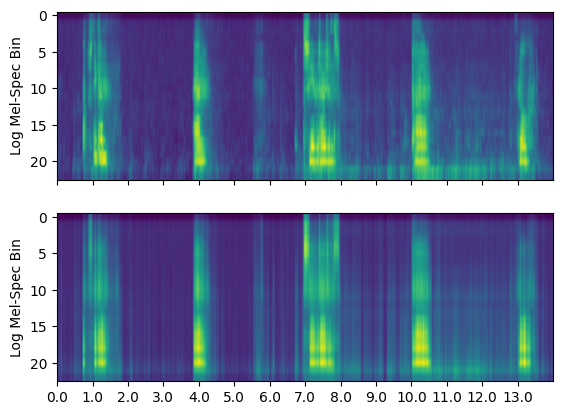

In [56]:
# Viz example spectrogram
#Which timeframe to plot
start_s = 5.5
stop_s = 19.5

frameshift = 0.01
#Load spectrograms
rec_spec = predictions_final
spectrogram = _spectrogram
#Load prompted words
#eeg_sr= 1024
#words = np.load(os.path.join(feat_path,f'{participant}_procWords.npy'))[int(start_s*eeg_sr):int(stop_s*eeg_sr)]
#words = [words[w] for w in np.arange(1,len(words)) if words[w]!=words[w-1] and words[w]!='']

os.makedirs(os.path.join(result_path), exist_ok=True)

cm='viridis'
fig, ax = plt.subplots(2, sharex=True)
#Plot spectrograms
pSta=int(start_s*(1/frameshift));pSto=int(stop_s*(1/frameshift))
ax[0].imshow(np.flipud(spectrogram[pSta:pSto, :].T), cmap=cm, interpolation=None,aspect='auto')
ax[0].set_ylabel('Log Mel-Spec Bin')
ax[1].imshow(np.flipud(rec_spec[pSta:pSto, :].T), cmap=cm, interpolation=None,aspect='auto')
plt.setp(ax[1], xticks=np.arange(0,pSto-pSta,int(1/frameshift)), xticklabels=[str(x/int(1/frameshift)) for x in np.arange(0,pSto-pSta,int(1/frameshift))])
#plt.setp(ax[1], xticks=np.arange(int(1/frameshift),spectrogram[pSta:pSto, :].shape[0],3*int(1/frameshift)), xticklabels=words)
ax[1].set_ylabel('Log Mel-Spec Bin')

plt.savefig(os.path.join(result_path,'spec_example_baseline.png'),dpi=600)

plt.show()

### Audio output

In [32]:
def createAudio(spectrogram, audiosr=16000, winLength=0.05, frameshift=0.01):
  """
  Create a reconstructed audio wavefrom

  Parameters
  ----------
  spectrogram: array
  Spectrogram of the audio
  sr: int
  Sampling rate of the audio
  windowLength: float
  Length of window (in seconds) in which spectrogram was calculated
  frameshift: float
  Shift (in seconds) after which next window was extracted
  Returns
  ----------
  scaled: array
  Scaled audio waveform
  """
  mfb = mel.MelFilterBank(int((audiosr*winLength)/2+1), spectrogram.shape[1], audiosr)
  nfolds = 1
  hop = int(spectrogram.shape[0]/nfolds)
  rec_audio = np.array([])
  for_reconstruction = mfb.fromLogMels(spectrogram)
  for w in range(0,spectrogram.shape[0],hop):
    spec = for_reconstruction[w:min(w+hop,for_reconstruction.shape[0]),:]
  rec = rW.reconstructWavFromSpectrogram(spec,spec.shape[0]*spec.shape[1],fftsize=int(audiosr*winLength),overlap=int(winLength/frameshift))
  rec_audio = np.append(rec_audio,rec)
  scaled = np.int16(rec_audio/np.max(np.abs(rec_audio)) * 32767)
  return scaled

In [33]:
audiosr = 16000
winLength = 0.05
frameshift = 0.01
np.save(os.path.join(result_path,f'{pt}_predicted_spec_final.npy'), predictions_final)
#Synthesize waveform from spectrogram using Griffin-Lim
reconstructedWav = createAudio(predictions_final,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join(result_path,f'{pt}_predicted_final.wav'),int(audiosr),reconstructedWav)

In [34]:
#For comparison synthesize the original spectrogram with Griffin-Lim
origWav = createAudio(_spectrogram,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join(result_path,f'{pt}_orig_synthesized_final.wav'),int(audiosr),origWav)

In [ ]:
from IPython.display import Audio, display
print("Original synthesized\n")
display(Audio(os.path.join(result_path,f'{pt}_orig_synthesized_final.wav'), autoplay=False))
print("\nPredicted\n")
display(Audio(os.path.join(result_path,f'{pt}_predicted_final.wav'), autoplay=False))

# Simple Ensemble

In [57]:
# Convert X_test to the appropriate data type and shape for predictions
# Ensemble the predictions
ensemble = 0.5 * predictions_baseline + 0.5 * predictions_final

# Calculate metrics for the ensemble model
ensemble_mae = mean_absolute_error(_spectrogram, ensemble)
ensemble_mse = mean_squared_error(_spectrogram, ensemble)
ensemble_r2 = r2_score(_spectrogram, ensemble)
# Create a DataFrame to store the results
ensemble_results = pd.DataFrame({'MAE': [ensemble_mae], 'MSE': [ensemble_mse], 'R2 Score': [ensemble_r2]})
# Save the results to a CSV file
ensemble_results.to_csv(os.path.join(result_path, 'ensemble_results.csv'), index=False)
print(ensemble_results)

        MAE       MSE  R2 Score
0  0.467186  0.472628  0.854488


### Visualisation

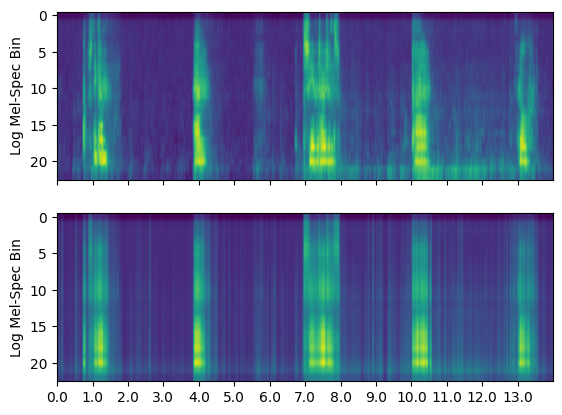

In [58]:
# Viz example spectrogram
#Which timeframe to plot
start_s = 5.5
stop_s = 19.5

frameshift = 0.01
#Load spectrograms
rec_spec = ensemble
spectrogram = _spectrogram
#Load prompted words
#eeg_sr= 1024
#words = np.load(os.path.join(feat_path,f'{participant}_procWords.npy'))[int(start_s*eeg_sr):int(stop_s*eeg_sr)]
#words = [words[w] for w in np.arange(1,len(words)) if words[w]!=words[w-1] and words[w]!='']

os.makedirs(os.path.join(result_path), exist_ok=True)

cm='viridis'
fig, ax = plt.subplots(2, sharex=True)
#Plot spectrograms
pSta=int(start_s*(1/frameshift));pSto=int(stop_s*(1/frameshift))
ax[0].imshow(np.flipud(spectrogram[pSta:pSto, :].T), cmap=cm, interpolation=None,aspect='auto')
ax[0].set_ylabel('Log Mel-Spec Bin')
ax[1].imshow(np.flipud(rec_spec[pSta:pSto, :].T), cmap=cm, interpolation=None,aspect='auto')
plt.setp(ax[1], xticks=np.arange(0,pSto-pSta,int(1/frameshift)), xticklabels=[str(x/int(1/frameshift)) for x in np.arange(0,pSto-pSta,int(1/frameshift))])
#plt.setp(ax[1], xticks=np.arange(int(1/frameshift),spectrogram[pSta:pSto, :].shape[0],3*int(1/frameshift)), xticklabels=words)
ax[1].set_ylabel('Log Mel-Spec Bin')

plt.savefig(os.path.join(result_path,'spec_example_baseline.png'),dpi=600)

plt.show()

### Audio output

In [38]:
def createAudio(spectrogram, audiosr=16000, winLength=0.05, frameshift=0.01):
  """
  Create a reconstructed audio wavefrom

  Parameters
  ----------
  spectrogram: array
  Spectrogram of the audio
  sr: int
  Sampling rate of the audio
  windowLength: float
  Length of window (in seconds) in which spectrogram was calculated
  frameshift: float
  Shift (in seconds) after which next window was extracted
  Returns
  ----------
  scaled: array
  Scaled audio waveform
  """
  mfb = mel.MelFilterBank(int((audiosr*winLength)/2+1), spectrogram.shape[1], audiosr)
  nfolds = 1
  hop = int(spectrogram.shape[0]/nfolds)
  rec_audio = np.array([])
  for_reconstruction = mfb.fromLogMels(spectrogram)
  for w in range(0,spectrogram.shape[0],hop):
    spec = for_reconstruction[w:min(w+hop,for_reconstruction.shape[0]),:]
  rec = rW.reconstructWavFromSpectrogram(spec,spec.shape[0]*spec.shape[1],fftsize=int(audiosr*winLength),overlap=int(winLength/frameshift))
  rec_audio = np.append(rec_audio,rec)
  scaled = np.int16(rec_audio/np.max(np.abs(rec_audio)) * 32767)
  return scaled

In [39]:
audiosr = 16000
winLength = 0.05
frameshift = 0.01
np.save(os.path.join(result_path,f'{pt}_predicted_spec_ensemble.npy'), ensemble)
#Synthesize waveform from spectrogram using Griffin-Lim
reconstructedWav = createAudio(ensemble,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join(result_path,f'{pt}_predicted_ensemble.wav'),int(audiosr),reconstructedWav)

In [40]:
#For comparison synthesize the original spectrogram with Griffin-Lim
origWav = createAudio(_spectrogram,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join(result_path,f'{pt}_orig_synthesized_ensemble.wav'),int(audiosr),origWav)

In [ ]:
from IPython.display import Audio, display
print("Original synthesized\n")
display(Audio(os.path.join(result_path,f'{pt}_orig_synthesized_ensemble.wav'), autoplay=False))
print("\nPredicted\n")
display(Audio(os.path.join(result_path,f'{pt}_predicted_ensemble.wav'), autoplay=False))